# Manipulação de Imagens RGB

Our image pre-processing consists in the following steps:
a) Image conversion to gray scale
b) Flatenning 2D->1D conversion


## **1. Importações**

In [2]:
%matplotlib inline
#pip install -U scikit-learn
#pip install imagehash
#pip install -U matplotlib

import sklearn

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

from sklearn.feature_selection import SequentialFeatureSelector

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors

from sklearn.cluster import DBSCAN, KMeans

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import  classification_report

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier

from sklearn.neighbors import KNeighborsClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier

from sklearn.neural_network import MLPClassifier

from sklearn.naive_bayes import GaussianNB

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
sns.set()

from PIL import Image

import imagehash

import numpy as np
from numpy import mean
from numpy import isnan
from numpy import asarray
from numpy import polyfit

import statistics

import os
import shutil, glob, os.path

from random import shuffle

from tqdm import tqdm

from scipy.stats import pearsonr

import math

import skimage
from skimage import data, io, color
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu 
from skimage.feature import canny 

import time

## **2. Leitura das imagens na pasta**

files:  ['short_image4.png', 'short_image2.png', 'short_image3.png', 'short_image1.png']
number of colors 3


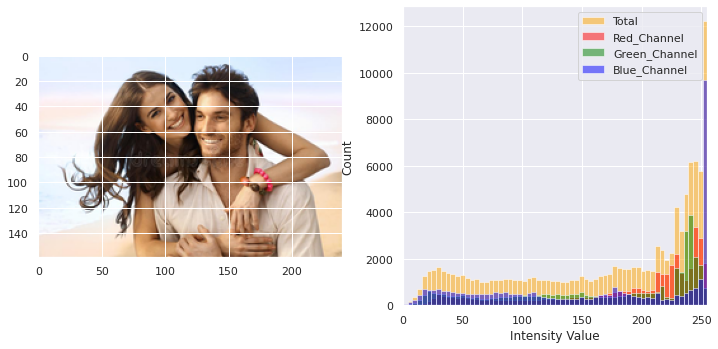

number of colors 3


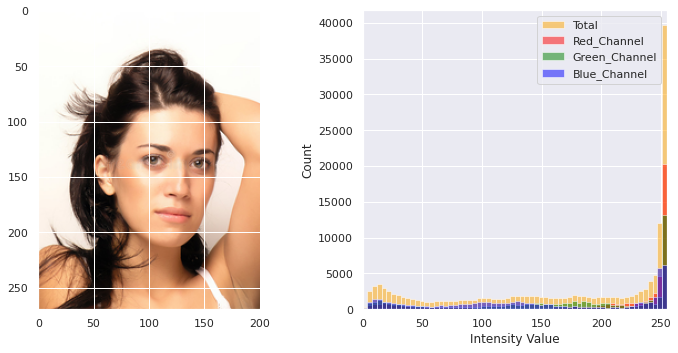

number of colors 3


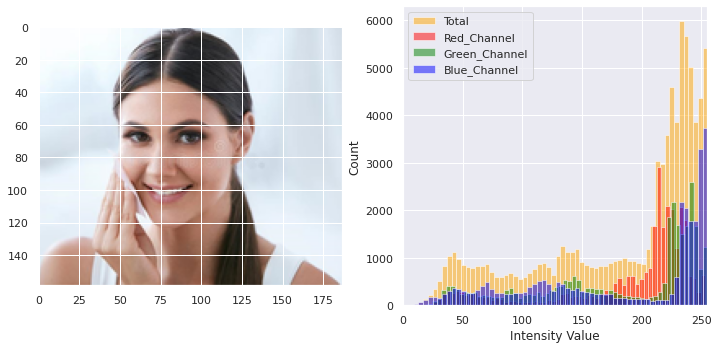

number of colors 3


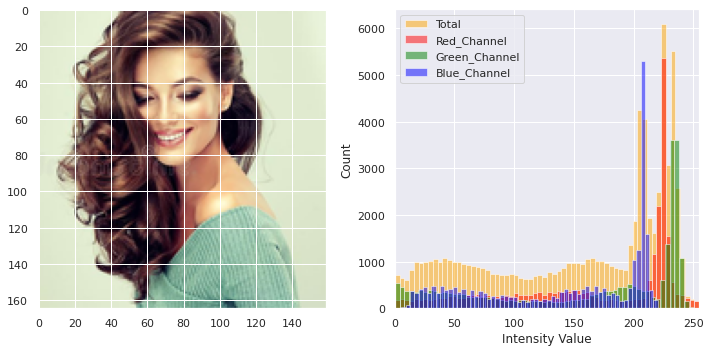

number of images =  4


In [3]:
#contagem e verificação das imagens

INPUT_PATH = './faces'

# 'D:/Users/diego/Google Drive/UNEB/ADocencia/EP/datasets/short_faces'

# 'D:/Users/diego/Google Drive/NOTEBOOKS/IA WORKS/Segmentation/python-kmeans-samuel/faces'

Files=os.listdir(INPUT_PATH)
print("files: ", os.listdir(INPUT_PATH))

as_gray = False #True para trabvalhar com imagens em escala de cinza

if as_gray:
    print("Using Gray Scale Segmentation .............")
    
img=[]
ncolors=[]
ResX=[]
ResY=[]
n=[]

num_img_to_load=4

for filename in Files[:num_img_to_load]:
    
    if filename.endswith('.jpg') or filename.endswith('.png'):
        try:
            img.append(io.imread(INPUT_PATH+"/"+filename))#, as_gray=as_gray)) # open the image file
            fig2, ax2 = plt.subplots(1,2, figsize=(12, 5.5))
            ncolors.append(img[-1].shape[-1])
            ResX.append(img[-1].shape[0])
            ResY.append(img[-1].shape[1])
            n.append(ResX[-1]*ResY[-1])
            print("number of colors", ncolors[-1])
            if not as_gray: 
                ax2[0].imshow(img[-1])
                if ncolors[-1]>1:
                    ax2[1].hist(img[-1].ravel(), bins = 64, color = 'orange', alpha = 0.5)
                    ax2[1].hist(img[-1][:, :, 0].ravel(), bins = 64, color = 'Red', alpha = 0.5)
                    ax2[1].hist(img[-1][:, :, 1].ravel(), bins = 64, color = 'Green', alpha = 0.5)
                    ax2[1].hist(img[-1][:, :, 2].ravel(), bins = 64, color = 'Blue', alpha = 0.5)
                    ax2[1].legend(['Total', 'Red_Channel', 'Green_Channel', 'Blue_Channel'])
            else:
                plt.style.use('grayscale')
                if ncolors[-1]>1: # if it is RGB convert to grayscale
                    img[-1]=np.round(255*rgb2gray(img[-1]))
                ncolors[-1]=1
                ax2[0].imshow(img[-1])
               
                ax2[1].hist(img[-1].ravel(), bins = 64)        
            ax2[1].set_xlim(0, 255)
            ax2[1].set_xlabel('Intensity Value')
            ax2[1].set_ylabel('Count')
            plt.show()
        except (IOError, SyntaxError) as e:
            print('Bad file:', filename)
            #os.remove(base_dir+"\\"+filename) (Maybe)

nImg=len(img)
print("number of images = ",nImg)


## **5. Implementação do K-Means**

In [3]:
# implementa o algoritmo k-means

def kmeans(image, K, ncolors):
    
    tempo_inicio = time.time() #  MUDEI A FUNÇÃO DO TEMPO
    
    cc = np.zeros((ncolors,K),dtype=int) # cria vetor (matrix) de centroides
    
    tamanho = image.shape[1]
#     print("shape do vetor: ", image.shape)
    
    # inicializa vetor de classificacao
    classificacao = [-1 for i in range(tamanho)]
    
    # INICIALIZA CENTROIDES --> MUDEI A INICIALIZAÇÃO - DEIXOU DE SER ALEATORIA - DIVIDO O INTERVALO DE 0-255 EM TANTOS PONTOS COMO CLASSES
    for c in range(ncolors):
        Mc=np.max(image[c])
        mc=np.min(image[c])
        for k in range(K):
            cc[c,k]=int(mc+k*(Mc-mc)/(K-1))
           
    INIT_TIME = time.time() - tempo_inicio
    
#     print("Init time: ",INIT_TIME)
    
    tempo_inicio = time.time()
    
    # PROCESSO ITERATIVO
    iteracoes = 0
    
    while True:
        
        point_cluster = [0 for i in range(K)] # ISTO É A ANTIGA VARIAVEL "m"
        
        iteracoes+=1
        
        mudanca = 0
        
        for i in range(tamanho):
            
            distancia_minima = 1e30
            k_menor = K+1
            
            for k in range(K): # varrendo os clusters
                
                distancia=0
                
                for c in range(ncolors):
                    distancia += np.abs(image[c][i]-cc[c][k]) # MUDEI A FUNCAO DE DISTANCIA ...int(np.power(image[c][i]-cc[c][k],2)) #forma L2 para calcular a distância do RGB do pixel em relação ao RGB do cluster
                
                if distancia < distancia_minima:
                    distancia_minima = distancia
                    k_menor = k
        
            
            if classificacao[i] != k_menor:
                classificacao[i] = k_menor # define o cluster a que pertence o pixel
                mudanca = 1
        
            point_cluster[classificacao[i]]+=1
            
        if mudanca == 0:
            ITER_TIME = time.time() - tempo_inicio
            break
    
        else: # CALCULO DOS NOVOS CENTROIDES
            
            for i in range(tamanho):
                for c in range(ncolors):    
                    cc[c][classificacao[i]]+= image[c][i] # SOMO AS CORES EM CADA CANAL DOS PIXELS DE CADA CLUSTER
                    
            for k in range(K):                     
                if point_cluster[k]>0:
                    for c in range(ncolors):    
                        cc[c][k]= int(cc[c][k]/point_cluster[k]) # DIVIDO A SOMA PELO NUMERO DE PONTOS EM CADA CLUSTER PARA ACHAR A MEDIA (CENTROIDE)
                else:
                    print(" cluster ",k," sem pontos ") # SE DER ESTA MENSAGEM ALGUMA COISA ESTÁ MAL .....
                   
    return INIT_TIME, ITER_TIME, iteracoes, classificacao, point_cluster # RETORNA TODAS AS VARIAVEIS NECESSARIAS



## **6. Teste do Kmeans**
### **Instruções:**
#### Antes de executar os testes pela primeira vez, é necessário rodar os blocos 1, 2 e 5. Depois da primeira execução, pode-se executar os testes diretamente.
### Sobre os resultados:
#### A classificação dos pixels em cada rodada de testes será encontrada na pasta classificações. A nomeclatura utilizada é: class_nome-imagem_rodada_k-numero-clusters.txt. Ex.: 64x64_1_k-2.txt
#### Os tempos de execução serão encontrados na pasta raiz. A nomeclatura utilizda é: nome-imagem_numero-clusters.txt. Ex.: 64x64_2.txt
#### O arquivo de tempos de execução contém o tempo e ao lado, o número de iterações necessárias para se obter o resultado na rodada.

In [4]:
# transforma imagens em vetores

Images=[]

for my_img in range(nImg):

    image=img[my_img]

    ch=[] # color channel vectors 

    for c in range(ncolors[my_img]):
        if ncolors[my_img]>1:
            ch.append(image[:ResX[my_img],:ResY[my_img],c].flatten()) 
        else:
            ch.append(image[:ResX[my_img],:ResY[my_img]].flatten())

    ch=np.array(ch)
    print(ch)
    Images.append(ch)

[[227 227 228 ... 220 221 211]
 [239 239 240 ... 193 194 184]
 [255 255 255 ... 158 161 152]]
[[255 255 255 ... 100 148 158]
 [255 255 255 ...  63 127 139]
 [253 253 253 ...  41 118 128]]
[[252 252 252 ... 176 223 226]
 [253 253 253 ... 157 224 237]
 [255 255 255 ... 152 234 249]]
[[223 224 224 ... 213 213 213]
 [233 234 234 ... 223 223 223]
 [206 207 207 ... 198 198 198]]


In [5]:
# BATERIA DE EXPERIMENTOS --> ADAPTAR À FORMA DE VCS

RODADAS_BENCHMARK = 20
MIN_CLUSTERS = 2
MAX_CLUSTERS = 6 # ao definir o número máximo de clusters, somar + 1. Ex.: para execução com max 5 clusters, definir MAX_CLUSTERS como 5+1 (por conta do funcionamento da função range() do python).


for k in range(MIN_CLUSTERS,MAX_CLUSTERS):
    
    print("")
    print("Number of Clusters ",k," ---------------------------------------------------------------------------- ")
    
    for i in range(nImg):
        
        print("")
        print("Image ",i+1," Resolution ",ResX[i],"x",ResY[i]," Pixel number ",ResX[i]*ResY[i], " .....................")
        print(" ")

        for bench in range(RODADAS_BENCHMARK):
            
            print("Run ",bench+1)
            
            [InitTime, IterTime, iterations, clusters, ptclust]=kmeans(Images[i], k, ncolors[i]) 

            with open('./imagem' + str(i+1) + '_' + str(k) + 'clusters' + '_init.txt', 'a') as filehandle:
                filehandle.write(str(InitTime)+'\n')
            with open('./imagem' + str(i+1) + '_' + str(k) + 'clusters' + '_iter.txt', 'a') as filehandle:
                filehandle.write(str(IterTime)+'\n')
            with open('./imagem' + str(i+1) + '_' + str(k) + 'clusters' + '_iterations.txt', 'a') as filehandle:
                filehandle.write(str(iterations)+'\n')

            print("Initiation time ",InitTime," Iterative Process Time ",IterTime," Iteration number ",iterations," Pixels per cluster ",ptclust)
            


Number of Clusters  2  ---------------------------------------------------------------------------- 

Image  1  Resolution  159 x 240  Pixel number  38160  .....................
 
Run  1
Initiation time  0.0015344619750976562  Iterative Process Time  8.552106618881226  Iteration number  10  Pixels per cluster  [14718, 23442]
Run  2
Initiation time  0.0017251968383789062  Iterative Process Time  8.527043342590332  Iteration number  10  Pixels per cluster  [14718, 23442]
Run  3
Initiation time  0.002199888229370117  Iterative Process Time  8.565267324447632  Iteration number  10  Pixels per cluster  [14718, 23442]
Run  4
Initiation time  0.0016913414001464844  Iterative Process Time  8.581694602966309  Iteration number  10  Pixels per cluster  [14718, 23442]
Run  5
Initiation time  0.0017879009246826172  Iterative Process Time  8.576930522918701  Iteration number  10  Pixels per cluster  [14718, 23442]
Run  6
Initiation time  0.002246379852294922  Iterative Process Time  8.5614094734191

## **Algoritmo de Benchmark**

In [7]:
BENCHMARK_TESTE = 100

with open('./benchmark.txt', 'w') as filehandle:
    filehandle.write(str(''))

for i in range(BENCHMARK_TESTE):
    if i % 10 == 0:
        print("Índice: ", i)
    bench_ini = time.time()
    for k in range(500000):
        resultado = k**500
    with open('./benchmark.txt', 'a') as filehandle:
        filehandle.write(str(time.time() - bench_ini) + '\n')





Índice:  0
Índice:  10
Índice:  20
Índice:  30
Índice:  40
Índice:  50
Índice:  60
Índice:  70
Índice:  80
Índice:  90


In [6]:
# RODADAS_BENCHMARK = 20 # número de rodadas em que o kmeans será executado.
# MIN_CLUSTERS = 2
# MAX_CLUSTERS = 6 # ao definir o número máximo de clusters, somar + 1. Ex.: para execução com max 5 clusters, definir MAX_CLUSTERS como 5+1 (por conta do funcionamento da função range() do python).

# def benchmark(n, k, nome_imagem): # n é o número de vezes que o kmeans será executado e k o número de clusters a ser passado para o método kmeans
#   with open('./' + nome_imagem + '.txt', 'w') as filehandle:
#     filehandle.write("")
#   for i in range(n):
#     total_iteracoes = kmeans(v, k)
#     with open('./' + nome_imagem + '.txt', 'a') as filehandle:
#       filehandle.write(str(tempo_execucao) + " - " + str(total_iteracoes))
#       filehandle.write("\n")
#     with open('./classificacoes/class_' + nome + '_' + str(i+1) + '_k-' + str(k) + '.txt', 'w') as filehandle:
#       filehandle.write(str(classificacao))

# for i in range(len(Files)): # Alterar para resolucao
#   v.clear() 
#   nome = str(Files[i].split('.')[0])
#   path=os.path.join(INPUT_PATH, Files[i])
#   processar_imagem(path)
#   for k in range(MIN_CLULSTERS, MAX_CLUSTERS):
#     benchmark(RODADAS_BENCHMARK, k, nome + '_' + str(k))
